In [30]:
# Importing libraries
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import kagglehub

In [31]:
# Data pre-processing
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 100

In [32]:
# Download dataset from Kaggle
path = kagglehub.dataset_download("gunavenkatdoddi/eye-diseases-classification")
print("Path to dataset files:", path)

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(path, "dataset"),
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Using Colab cache for faster access to the 'eye-diseases-classification' dataset.
Path to dataset files: /kaggle/input/eye-diseases-classification
Found 4217 files belonging to 4 classes.


In [33]:
class_names = dataset.class_names
print(class_names)

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


In [34]:
print("Number of batches in the dataset:", len(dataset))

Number of batches in the dataset: 132


In [35]:
# Dataset Split Criteria
# 80% ==> training
# 10% ==> validation
# 10% ==> testing

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)
    return train_ds, val_ds, test_ds

In [41]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [40]:
print("Number of training batches:", len(train_ds))
print("Number of validation batches:", len(val_ds))
print("Number of testing batches:", len(test_ds))

Number of training batches: 105
Number of validation batches: 13
Number of testing batches: 14


In [39]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [42]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [43]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [44]:
# Model Building
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [45]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 4)                │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,812 (718.02 KB)

 Trainable params: 183,812 (718.02 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [47]:
# Define callbacks for Early Stopping and Model Checkpoint
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [48]:
# Train the model with the callbacks
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.3331 - loss: 1.3379
Epoch 1: val_accuracy improved from -inf to 0.50721, saving model to best_model.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 45s 220ms/step - accuracy: 0.3337 - loss: 1.3372 - val_accuracy: 0.5072 - val_loss: 1.0767
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5244 - loss: 1.0803
Epoch 2: val_accuracy improved from 0.50721 to 0.56490, saving model to best_model.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 41s 225ms/step - accuracy: 0.5245 - loss: 1.0797 - val_accuracy: 0.5649 - val_loss: 0.9451
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5884 - loss: 0.8907
Epoch 3: val_accuracy improved from 0.56490 to 0.63462, saving model to best_model.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 40s 224ms/step - accuracy: 0.5887 - loss: 0.8903 - val_accuracy: 0.6346 - val_loss: 0.7757
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6666 - loss: 0.7584
Epoch 4: val_accuracy im

In [55]:
scores = model.evaluate(test_ds)
print(f"Test Loss: {scores[0]:.4f}")
print(f"Test Accuracy: {scores[1]:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.9091 - loss: 0.2180
Test Loss: 0.2051
Test Accuracy: 0.9129


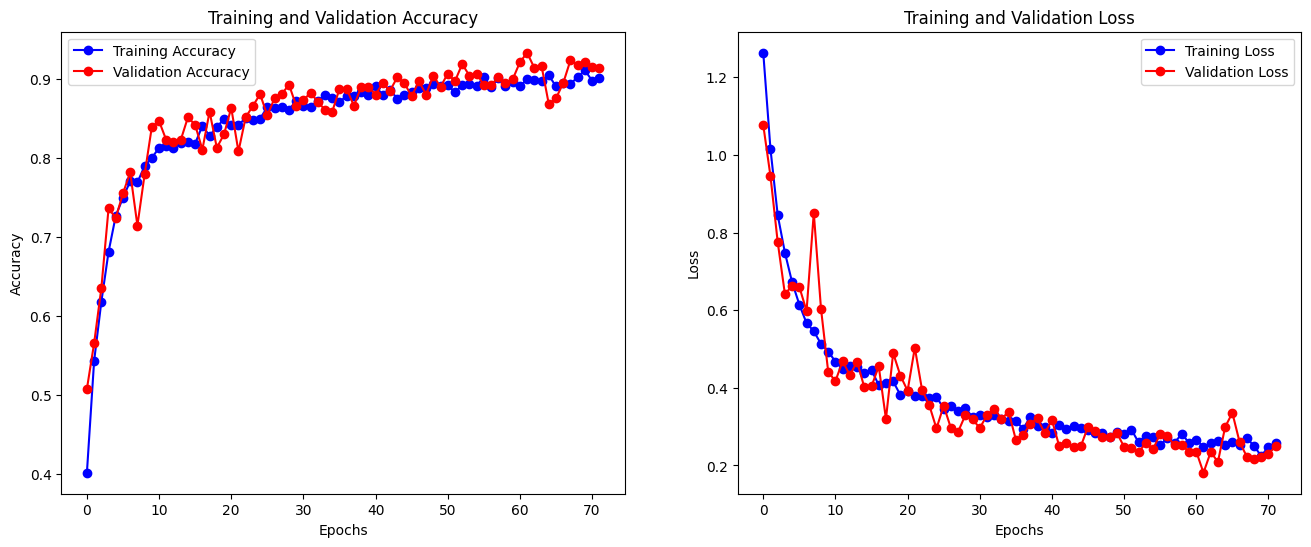

In [56]:
# Visualization of Training and Validation Performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Classification Report:
                      precision    recall  f1-score   support

            cataract       0.94      0.94      0.94       115
diabetic_retinopathy       0.99      0.99      0.99       113
            glaucoma       0.84      0.83      0.84       103
              normal       0.86      0.86      0.86       117

            accuracy                           0.91       448
           macro avg       0.91      0.91      0.91       448
        weighted avg       0.91      0.91      0.91       448



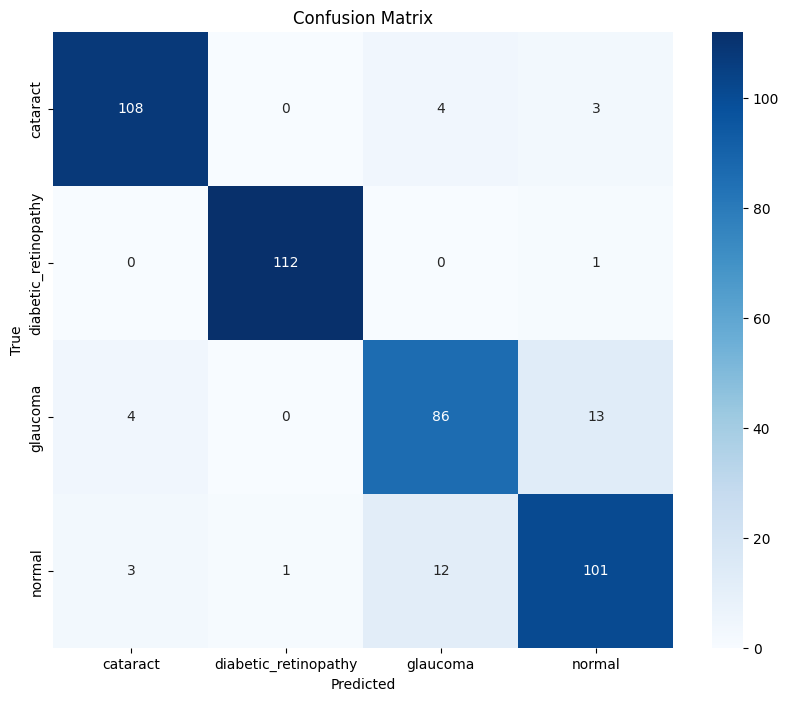

In [57]:
# Detailed Performance Metrics (Classification Report and Confusion Matrix)
y_true = []
y_pred = []
for images, labels in test_ds:
    predictions = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

First image to predict


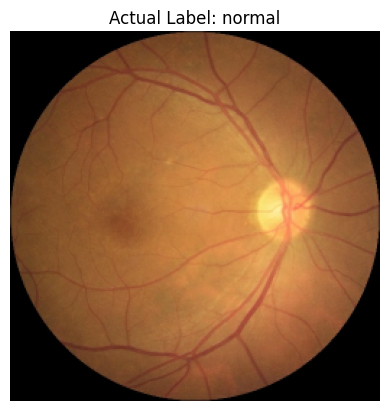

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted Label: normal
Confidence: 96.33999633789062%


In [58]:
# Model Prediction on Single Image
def predict_image(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First image to predict")
    plt.imshow(first_image)
    plt.title(f"Actual Label: {class_names[first_label]}")
    plt.axis("off")
    plt.show()

    predicted_class, confidence = predict_image(model, first_image)
    print(f"Predicted Label: {predicted_class}")
    print(f"Confidence: {confidence}%")

In [59]:
model.save("my_model.keras")

In [60]:
from google.colab import files
files.download("my_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>